# ***Fazer login no google para importar automaticamente a imagem do Classroom***

In [ ]:
!pip install PyDrive

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
images_configs = [
  {
      "id": "10t6ityvFHc7u1q_07qop7-_wI7bEm1Yx",
      "name": "lena.ascii.pgm"
  },
  {
      "id": "1rjYygn53m48abG0MyVl7VrR3-tZNDqEv",
      "name": "baboon_ascii.pgm"
  }
]

for config in images_configs: 
    img = drive.CreateFile({ "id": config["id"] })
    img.GetContentFile(config["name"])

# ***Codificando as imagens***

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import json
from heapq import heappush, heappop, heapify
from collections import defaultdict

**Abre e estrututa a imagem**

In [6]:
def open_image(fname):
    with open(fname) as f:
        lines = f.readlines()

    for l in list(lines):
        if l[0] == '#':
            lines.remove(l)

    data = []
    for line in lines[1:]:
        data.extend([int(c) for c in line.split()])

    vmax = data[2]
    dimensions = (data[1],data[0])
    image_flat = np.array(data[3:])

    image = np.reshape(image_flat, dimensions)
    plt.imshow(image, cmap='gray', vmin=0, vmax=vmax)
    
    return image_flat, dimensions, vmax

**Faz a analise de frequencia**

In [7]:
def calc_freqs(image):
    freqs = {}
    total = 0

    for pixel in image:
        key = str(pixel)
        total += 1
        if freqs.get(key, False):
            freqs[key] += 1
        else:
            freqs[key] = 1
    return freqs, total

**Calcula Huffman**

In [8]:
def huffman(freqs):
    heap = [[wt, [sym, ""]] for sym, wt in freqs.items()]
    heapify(heap)
    while len(heap) > 1:
        lo = heappop(heap)
        hi = heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])
    codewords = {}
    for sym, wt in heap[0][1:]:
        codewords[sym] = wt
    return codewords

**Salva codewords em arquivo**

In [9]:
def save_codewords(name, codewords, dimensions, vmax):
    content = json.dumps({
        "codewords": codewords,
        "dimensions": dimensions,
        "vmax": vmax
    })
    f = open(f"{name}.json","w")
    f.write(content)
    f.close()

**Codifica e salva imagem em arquivo**

In [10]:
def code_and_save_image(name, image, codewords, dimensions, vmax):
    # Code as binary
    code = ""
    for pixel in image:
        key = str(pixel)
        code += codewords[key]
    
    content = json.dumps({
        "codewords": codewords,
        "dimensions": dimensions,
        "vmax": vmax,
        "code": code
    }, indent=4)

    f = open(f"{name}.huff","w")
    f.write(content)
    f.close()

**Calcula comprimento medio de codewords**

In [11]:
def avg_codeword(codewords, freqs, total):
    avg = 0
    for key in codewords:
        avg += len(codewords[key]) * freqs[key]
    return avg/total

**Execucao**

O comprimento medio do codeword para lena.ascii.pgm eh: 7.467304229736328
O comprimento medio do codeword para baboon_ascii.pgm eh: 7.380626678466797


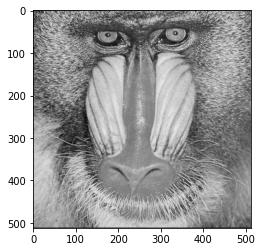

In [12]:
for config in images_configs: 
    image, dimensions, vmax = open_image(config["name"])
    freqs, total = calc_freqs(image)
    codewords = huffman(freqs)
    code_and_save_image(config["name"], image, codewords, dimensions, vmax)
    print(f"O comprimento medio do codeword para {config['name']} eh: {avg_codeword(codewords, freqs, total)}")

# **Decodificando as Imagens**

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import json

**Abrir informacoes e code**

In [14]:
def open_image_info(name):
    f = open(f"{name}.huff", "r")
    content = f.read()
    info = json.loads(content)
    return info["codewords"], info["dimensions"], info["vmax"], info["code"]

**Inverter codewords**

In [15]:
def calc_decoder(codewords):
    decoder = {}
    for key in codewords:
        decoder[codewords[key]] = key
    return decoder

**Decodificar**

In [16]:
def decode_code(code, decoder):
    max_code_length = 0
    min_code_length = float("inf")
    for key in decoder:
        if max_code_length < len(key):
            max_code_length = len(key)
        if min_code_length > len(key):
            min_code_length = len(key)

    decoded = []
    while (len(code) > 0):
        for i in range(min_code_length, max_code_length + 1):
            if decoder.get(code[:i], False):
                decoded.append(int(decoder[code[:i]]))
                code = code[i:]
                break
    
    return decoded

**Mostrar imagem**

In [17]:
def save_image(name, image, dimensions, vmax):
    image_2d = np.reshape(np.array(image), dimensions)
    plt.imshow(image_2d, cmap='gray', vmin=0, vmax=vmax)

    image_copy = image.copy()
    content = f"P2\n{dimensions[0]} {dimensions[1]}\n{vmax}\n"
    for i in range(dimensions[0]):
        content += " ".join([str(el) for el in image_copy[:dimensions[1]]])
        content += "\n"
        image_copy = image_copy[dimensions[1]:]
    
    f = open(f"{name}.huff.pgm","w")
    f.write(content)
    f.close()

**Execucao (> 45 segundos)**

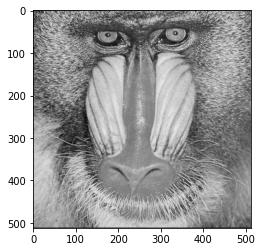

In [18]:
for config in images_configs:
    codewords, dimensions, vmax, code = open_image_info(config["name"])
    decoder = calc_decoder(codewords)
    image = decode_code(code, decoder)
    save_image(config["name"], image, dimensions, vmax)

# **Calculo do PSNR**

**Abrir imagens**

In [19]:
def open_image2(fname):
    with open(fname) as f:
        lines = f.readlines()

    for l in list(lines):
        if l[0] == '#':
            lines.remove(l)

    data = []
    for line in lines[1:]:
        data.extend([int(c) for c in line.split()])

    vmax = data[2]
    dimensions = (data[1],data[0])
    image = data[3:]

    return image, dimensions, vmax

**Calculo do PSNR**

In [20]:
def calc_psnr(original, decoded, vmax):
    MSE = 0
    for i in range(len(original)):
        MSE += (original[i] - decoded[i])**2
    
    if MSE == 0:
        return "infinito"
    else:
        return (vmax**2) / MSE

**Execucao**

In [21]:
for config in images_configs:
    image_original, _, vmax = open_image2(config["name"])
    image_decoded, *_ = open_image2(f'{config["name"]}.huff.pgm')
    # assert np.array_equal(image_original, image_decoded)
    print(f"O PSNR do processo para {config['name']} eh: {calc_psnr(image_original, image_decoded, vmax)}")

O PSNR do processo para lena.ascii.pgm eh: infinito
O PSNR do processo para baboon_ascii.pgm eh: infinito


Obteve-se o valor do PSNR infinito, ou seja, a compressão é do tipo sem
perdas, visto que a codificação de Huffman altera apenas a forma de armazenar a mesma informação.